# Import Modules 

In [24]:
from model.unet import UNet
from model.cnn import CNN
from utils.dataset import RXrayDataset, BXDataset, CXDataset, XrayDataset
from utils.evaluate import * 
from torch.utils.data import DataLoader 
from torch.utils.data import random_split 
from tqdm import tqdm 
import torch
import torch.nn.functional as F 
import albumentations as A 
import imageio
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch.nn as nn
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2
import pydicom as di
from scipy import ndimage
from torchinfo import summary
from pydicom.pixel_data_handlers.util import apply_voi_lut

# PSNR function

In [39]:
def PSNR(original, pred):
    mse = np.mean((original - pred) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    PSNR = 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
    return PSNR

def plot_images(images, cols=3):
#    plt.clf()
#    plt.figure(figsize(14,8))
    rows = math.ceil(images.shape[0]/cols)
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(14,5*rows))

    idx = 0
    for row in ax:
        for col in row:
            if idx > images.shape[0]-1:
                break
            im = images[idx,:,:]
            col.imshow(im, cmap=plt.cm.bone)
            col.title.set_text(idx)
            idx += 1
    plt.show()

def standardize(img,m,s):
    
    if m==0 and s==0:
        m = img.mean()
        s = img.std()
    
    img = (img - m)/s
    
    return img, m, s


def normal(img):
    return (img - img.min())/(img.max()-img.min())

def unstandardize(img, m, s):
    
    img = img*s + m
    
    return img

def imcrop(img):
    
    if len(img.shape) > 2:
        z, y, x = img.shape
        v = min(x,y,z)
    else:
        y, x = img.shape
        v = min(x,y)
            
    
    if len(img.shape) > 2:
        new_x=v
        new_y=v
        new_z=v

        left = int((y - new_y)/2)
        top = int((x - new_x)/2)
        right = int((y + new_y)/2)
        bottom = int((x + new_x)/2)
        z_top = int((z - new_z)/2)
        z_bottom = int((z + new_z)/2)
        
        k = img[z_top:z_bottom,left:right,top:bottom]
    else:
        new_x=v
        new_y=v

        left = int((y - new_y)/2)
        top = int((x - new_x)/2)
        right = int((y + new_y)/2)
        bottom = int((x + new_x)/2)
        
        k = img[left:right,top:bottom]
    
    return k

def resize_images(img,desired_width,desired_height,current_width,current_height): # img is 1024*1024

    width_index=current_width/desired_width
    height_index=current_height/desired_height

    width_factor=1/width_index
    height_factor=1/height_index
    
    img=ndimage.zoom(img,(width_factor,height_factor),order=3)
    
    return img

def process(path):
    
    image = np.load(path)
    
    mask = np.load(path.replace('xray','mask'))

#     image=image/image.max()

    image = np.float32(image)
    
    image = resize_images(image,512,512,image.shape[0],image.shape[1])
    
    mask = resize_images(mask,512,512,mask.shape[0],mask.shape[1])

    image, mc,sc = standardize(image,0,0)

#     mask = np.expand_dims(mask, axis=2)
    image = np.expand_dims(image, axis=2)

#     mask = np.transpose(mask, (2, 0, 1))
    image = np.transpose(image, (2, 0, 1))
    
    print(image.shape)
    print(mask.shape)
    
#     Xray = di.dcmread(path)
    
# #     image = apply_voi_lut(Xray.pixel_array, Xray)
    
#     image = Xray.pixel_array
    
#     if Xray.PhotometricInterpretation == 'MONOCHROME1':
#         image = np.amax(image) - image
        
# #     image = imcrop(image)

#     image = image/image.max()

#     image = np.float32(image)
    
#     image = resize_images(image,512,512,image.shape[0],image.shape[1])
    
#     image, mc,sc = standardize(image,0,0)

#     image = np.expand_dims(image, axis=2)

#     image = np.transpose(image, (2, 0, 1))

    return image, mask

def process2(path):
    
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

#     image=image/image.max()

    image = np.float32(image)
    
    image = resize_images(image,512,512,image.shape[0],image.shape[1])
    
    image, mc,sc = standardize(image,0,0)

#     mask = np.expand_dims(mask, axis=2)
    image = np.expand_dims(image, axis=2)

#     mask = np.transpose(mask, (2, 0, 1))
    image = np.transpose(image, (2, 0, 1))
    
#     Xray = di.dcmread(path)
    
# #     image = apply_voi_lut(Xray.pixel_array, Xray)
    
#     image = Xray.pixel_array
    
#     if Xray.PhotometricInterpretation == 'MONOCHROME1':
#         image = np.amax(image) - image
        
# #     image = imcrop(image)

#     image = image/image.max()

#     image = np.float32(image)
    
#     image = resize_images(image,512,512,image.shape[0],image.shape[1])

    return image

In [40]:
# path = './data/Test/Xray/'
# file = os.listdir(path)
# x = file[53]
# print(x)
# img = np.load(path+x)
# l = np.load(path[:-5]+'Lungs/'+x.replace('Xray','Lungs'))

In [41]:
# plt.imshow(img, cmap=plt.cm.bone)

In [42]:
# plt.imshow(l, cmap=plt.cm.bone)

# Parameter Set

# DATASET Defining

In [43]:
#image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
#image.max()
#plt.imshow(image, cmap=plt.cm.bone)
train_transforms = A.Compose(
    [
        A.Resize(width=512, height=512, p=1.0)
    ]
)

In [44]:
BATCH_SIZE_TEST = 1
model_iters = '13dth'
# test_xray_directory = 'data/Xray_real/real_4'
# test_xray_directory = '../vinbigdata/COVIDGR_1.0/N'
test_xray_directory = '../N_classifier/data/train/train_xray'
test_xray_filenames = os.listdir(test_xray_directory)

# test_xray_directory = 'data/Xray_real/cropped_4'
# test_xray_filenames = os.listdir(test_xray_directory)

# dataset_test = BXDataset(test_xray_filenames,test_xray_directory,transform = train_transforms)
# dataset_test = RXrayDataset(test_xray_filenames,test_xray_directory,transform = train_transforms)

In [45]:
# t_list = [s[:-4]+'.dicom' for s in test_xray_filenames]

In [46]:
# test_xray_filenames = t_list


# Model Creation

In [47]:
# x_list = os.listdir('../vinbigdata/test')
# x_list = [s[:-6] for s in x_list]
# x_list[0]

In [48]:
# import shutil

# source = "../vinbigdata/VinDr-CXR-mask/"
# dest = "../vinbigdata/test_mask/"
# i = 0
# for name in x_list:
#     i=i+1
#     print(i)
#     path = source + name + '.npy'
# #     print(path)
#     shutil.move(path, dest)

# Training Phase

In [49]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
model = UNet()
model= nn.DataParallel(model,device_ids = [0])
model  = torch.load('model_weights/'+model_iters+'/model1.ckpt')
# critic = DNN()
# critic= nn.DataParallel(critic,device_ids = [0])
# critic  = torch.load('model_weights/'+model_iters+'/next_best/critic1.ckpt')

In [53]:
from PIL import Image

model.eval()
pred = []
mk = []
xray = []
conf = []

# input_path = '../vinbigdata/test_xray'
xray_path = test_xray_directory
mask_path = test_xray_directory.replace('xray','mask')
lungs_path = test_xray_directory.replace('xray','lungs')
# input_path = '../COVIDx/train_X'

i = 0 

for name in test_xray_filenames:
    
#     if name[:-6] not in x_list:
#         print(name[:-6])
#         break
    path = os.path.join(test_xray_directory, name)

    images, mask = process(path)
    
#     print(mask.shape)

#         if images is not False:

    images = torch.from_numpy(images).unsqueeze(0)
#     print(images.shape)

    images = images.to(device=device, dtype=torch.float32)

#     images, _, _ = standardize(images,0,0)
    with torch.no_grad():
        mask_pred, _ = model(images)
#         loss = critic(mask_pred)
        images = images.cpu().detach().numpy().squeeze(0).squeeze(0)
        mask_pred = mask_pred.cpu().detach().numpy().squeeze(0).squeeze(0)
#         images = np.uint8(images*255)
        mask = np.uint8(mask*255)
        mask_pred = np.uint8(mask_pred*255)
        images = cv2.cvtColor(images, cv2.COLOR_GRAY2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
        mask_pred = cv2.cvtColor(mask_pred, cv2.COLOR_GRAY2RGB)
#         xray.append(images)
#         pred.append(mask_pred)
#         mk.append(mask)
        
#         mask_pred = resize_images(mask_pred,640,640,mask_pred.shape[0],mask_pred.shape[1])
#         loss = loss.cpu().detach().numpy().squeeze(0)
#         mask_pred[mask_pred<0.03]=0

        i = i + 1

#             pred.append(mask_pred)
#             xray.append(images)
#             conf.append(loss)

#         tmp_name = name.split('.')[0]
    
#         images = process2(path) 

#         np.save(input_path+'/'+tmp_name,images)
#         np.save(lungs_path+'/'+name,mask_pred)
        cv2.imwrite(xray_path+'_p/'+name[:-3]+'png',images)
        cv2.imwrite(mask_path+'_p/'+name[:-3]+'png',mask)
        cv2.imwrite(lungs_path+'_p/'+name[:-3]+'png',mask_pred)

        # Assuming your grayscale image is stored in a NumPy array called "image"
        # Ensure it's in the uint8 range [0, 255]
        # Convert to 8-bit unsigned integer (0-255)
#         mask_pred = plt.cm.bone(mask_pred)
#         mask_pred = Image.fromarray((mask_pred[:, :, :3] * 255).astype(np.uint8))
        
#         mask_pred = np.array(mask_pred, dtype=np.uint8)

#         # Create a PIL Image object from the NumPy array
#         mask_pred = Image.fromarray(mask_pred)

#         # Save the PIL Image object as a JPEG file
#         mask_pred.save(lungs_path+'/'+tmp_name +'_L.jpg')
        
#         images = process2(path) 
        
#         images = plt.cm.bone(images)
#         images = Image.fromarray((images[:, :, :3] * 255).astype(np.uint8))
        
#         images = np.array(images, dtype=np.uint8)

#         # Create a PIL Image object from the NumPy array
#         images = Image.fromarray(images)

#         # Save the PIL Image object as a JPEG file
#         images.save(lungs_path+'/'+tmp_name +'_X.jpg')
#         plt.imshow(mask_pred, cmap=plt.cm.bone)
#         break

        print(i)
        break
#         if i ==100:
#             break

(1, 512, 512)
(512, 512)
torch.Size([1, 1, 512, 512])
1


In [59]:
print(mask_pred.shape)

(512, 512, 3)


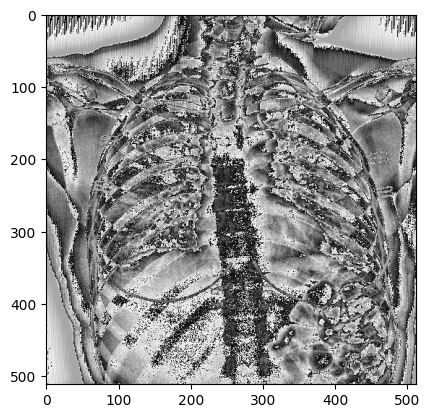

In [56]:
# x=6
# img = np.load(lungs_path+'/'+name)
plt.imshow(images, cmap=plt.cm.bone)

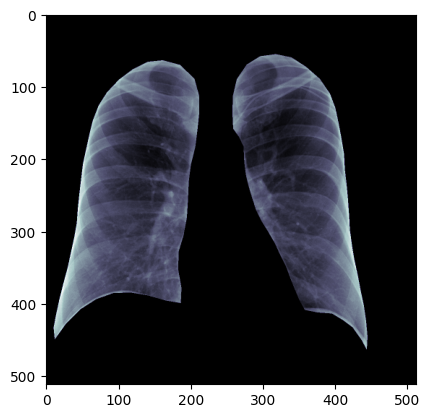

In [15]:
img = mk[x]
plt.imshow(img, cmap=plt.cm.bone)

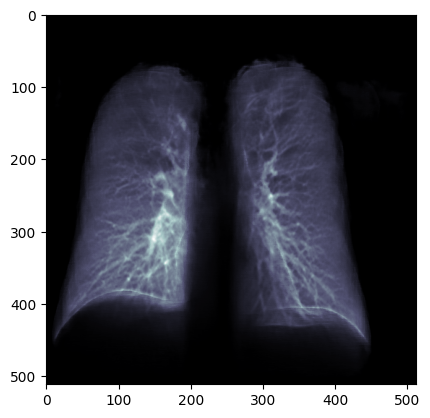

In [16]:
img = pred[x]
plt.imshow(img, cmap=plt.cm.bone)

In [17]:
# model.eval()
# pred = []
# xray = []
# # input_path = './data/Xray'
# # lungs_path = './data/Lungs'
# i = 0 
# for batch, (images) in enumerate(test_loader):
#     images = images.to(device=device, dtype=torch.float32)
# #     images, _, _ = standardize(images,0,0)
#     with torch.no_grad():
#         mask_pred, _ = model(images)
#         images = images.cpu().detach().numpy().squeeze(0).squeeze(0)
#         mask_pred = mask_pred.cpu().detach().numpy().squeeze(0).squeeze(0)
# #         mask_pred = mask_pred[0][0].cpu().detach().numpy()
# #         print(mask_pred.shape)
# #         mask_pred[mask_pred<0.03]=0
#         pred.append(mask_pred)
#         xray.append(images)
#         i = i + 1
#         if i==50:
#             break
# #         np.save(input_path+'/Xray_'+str(i),images)
# #         np.save(lungs_path+'/Lungs_'+str(i),mask_pred)

In [18]:
image = []
for x in range(len(pred)):
    im = xray[x]
#     im = np.transpose(im, (1, 2, 0))
#     print(im.shape)
#     break
#     im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
#     print(image.shape)
#     break
    image.append(im)
    image.append(pred[x])
    image.append(mk[x])


In [19]:
# plt.imshow(image[1], cmap=plt.cm.bone)
# image[0].shape

In [20]:
# lungs_path = './data/Lungs'
# L = os.listdir(lungs_path)
# idx = L[0][6:-4]
# idx = []
# for i in L:
#     idx.append(int(i[6:-4]))

In [21]:
# for i in range(1, 535):
#     if i not in idx:
#         print(i)

In [22]:
# input_path = './data/Xray'
# lungs_path = './data/Lungs'
# c = 1
# for i in range(0, len(image)):
#     if i % 2 == 0:
#         np.save(input_path+'/Xray_'+str(c),image[i].squeeze(2))
#     else:
#         np.save(lungs_path+'/Lungs_'+str(c),image[i])
#         c=c+1
    
# np.save(input_path+'/Luna16_Xray_'+str(i),CT_img2d)

In [23]:
# image = mask[62]
# plt.imshow(image, cmap=plt.cm.bone)

In [24]:
# lungs_path = './data/Lungs/Lungs_2.npy'

# # np.save(lungs_path,image)

# image = np.load(lungs_path)
# plt.imshow(image, cmap=plt.cm.bone)

In [25]:
# L[59]

# Erosion Dilation

In [26]:
# from skimage import io, morphology, measure
# import numpy as np

# lungs_path = './data/Lungs'
# new_path = './data/Mask'

# L = os.listdir(lungs_path)

# mask = []

# for x in range(0, len(L)):
    
#     temp_path = lungs_path + '/' + L[x]
#     image = np.load(temp_path)
#     save_path = new_path + '/' + L[x]
# #     mask.append(image)

#     img = (image > 0)*1

# #     plt.imshow(img, cmap=plt.cm.bone)
# #     plt.show()

#     kernel = np.ones((50, 50))

#     img = morphology.binary_erosion(img, footprint=kernel)
    
#     labeled_image = measure.label(img)

#     regions = measure.regionprops(labeled_image)
#     regions = sorted(regions, key=lambda region: region.area, reverse=True)

#     area_threshold = 40000

#     bw = np.zeros_like(image)
    
#     c=0
#     for region in regions:
#         area = region.area
#         label = region.label
#         if area >= area_threshold:
#             c=c+1
#             if c<=2:
#                 bw[labeled_image == label] = 1
#     img = bw

#     kernel = np.ones((50, 50))

#     img = morphology.binary_dilation(img, footprint=kernel)

#     image = image*img
    
# #     mask.append(image)

#     np.save(save_path,image)
    
#     print(x)
# #     if x ==100:
# #         break

# # plt.imshow(image, cmap=plt.cm.bone)
# # plt.show()

In [27]:
img=image[0:100]

# img = mask[:100]

In [28]:
# plt.imshow(img, cmap=plt.cm.bone)
# plt.show()

In [29]:
# plt.hist(img[98].ravel(), bins=256, range=(0.1,1))
# plt.show()

In [30]:
# i = img[24]

In [31]:
# counts, bins, patches = plt.hist((i).ravel(), bins = 256, range=(.05,i.max()))
# total = sum(counts)

# c_mx = np.argmax(counts)

# # clipu = 0.99*total
# # clipl = 0.99*total
# # for x in range(len(counts)):
# #     if sum(counts[:x])>=clipu:
# #         break
# # u=x
# # image[image>bins[u+1]] = bins[u+1]
# bins[c_mx]

In [32]:
# b = bins[c_mx]
# if b<.8:
#     d = .8-b
# elif b>.9:
#     d = .9 -b
# else:
#     d=0

# i = i + d    

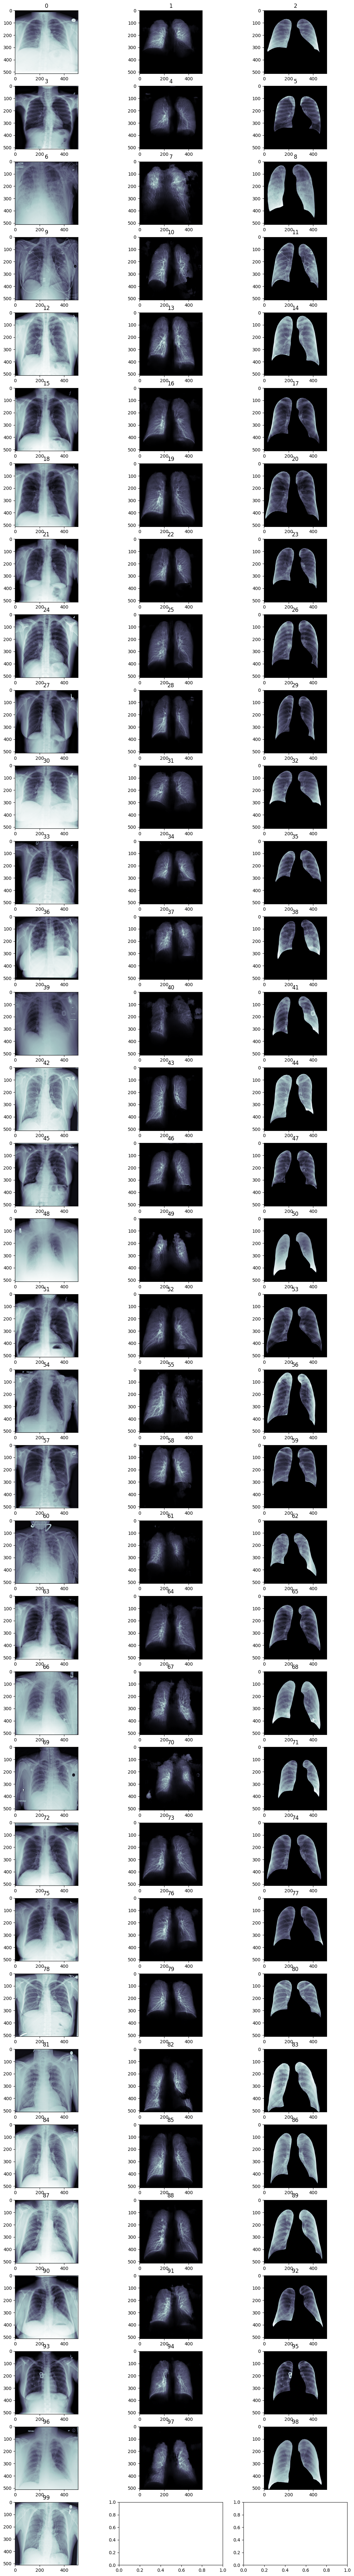

In [33]:
#plot_images(images, cols=3)
cols = 3
rows = math.ceil(len(img)/cols)
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(14,3*rows))

idx = 0
for row in ax:
    for col in row:
        if idx > len(img)-1:
            break 
        im = img[idx]
        col.imshow(im, cmap=plt.cm.bone)
        col.title.set_text(idx)
        idx += 1
plt.show()

In [34]:
# im = img[0]

In [35]:
# im = np.power(im,0.5)

## 